# Query transformer trained on different number of masses

### Setup

In [1]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
from acousticnn.mmo import get_dataloader, Iter_Dataset
from acousticnn.mmo import train
from acousticnn.utils.builder import build_opti_sche, build_model
from acousticnn.utils.logger import init_train_logger, print_log
from acousticnn.utils.argparser import get_args, get_config
from torchinfo import summary
import wandb 
import time
import os
import torch
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['axes.labelsize'] = 9
rcParams['axes.titlesize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams["figure.figsize"] = (10 / 2.54, 8 / 2.54)

In [3]:
def plot_loss(losses_per_f, f, ax=None, quantile=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    losses_per_f = losses_per_f.transpose(0, 2, 1).reshape(-1, 200)
    mean = np.mean(losses_per_f, axis=0)
    std = np.std(losses_per_f, axis=0)
    ax.semilogx(f, mean)
    if quantile is not None:
        quantiles = np.quantile(losses_per_f, [0+quantile, 1-quantile], axis=0)
        ax.fill_between(f, quantiles[0], quantiles[1], alpha=0.2)

    ax.set_xlabel('Angular frequency in rad/s')
    ax.set_ylabel('rmse dB re 1m')
    return ax

def plot_results(prediction, amplitude, f, ax=None, quantile=None, linestyle = '--'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 12))

    ax.semilogx(f, prediction, c='black', alpha = 0.8)
    ax.semilogx(f, amplitude, c='red', linestyle = linestyle)

    ax.grid(True)
    ax.set_xlabel('Angular frequency in rad/s')
    ax.set_ylabel('Amplitude in dB re 1m')
    return ax

In [4]:
args = get_args(["--config", "grid_mlp.yaml"])
args.encoding = "none"
config = get_config("configs/query_transformer.yaml")

def get_dataloader_helper(n_masses, n_samples, test, batch_size):
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    parameters_dataset = {"n_masses": n_masses, 
            "sample_f": False,
            "f_per_sample": 200,
            "sample_m": True,
            "m_range": (1, 25),
            "sample_d": True,
            "d_range": (0.1, 1),
            "sample_k": True,
            "k_range": (1, 30),
            "normalize": False,
            "normalize_factor": 10,
            "f_range": (-1.5, 1)
    }    
    if args.encoding == "none":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 10
        config.model.input_encoding = "none"
    elif args.encoding == "random":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 10
        config.model.input_encoding = "random"
    elif args.encoding == "sin":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 100
        config.model.input_encoding = "sin"
    else:
        raise NotImplementedError
    return get_dataloader(args, config, test=test, n_samples=n_samples, parameters=parameters_dataset, batch_size=batch_size)
valloader = get_dataloader_helper(4, 1000, True, 100)
f = np.logspace(-1.5, 1, 200)

{'n_masses': 4, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(12.9785) tensor(6.9809)
tensor(0.5434) tensor(0.2591)
tensor(15.3790) tensor(8.3880)
tensor(0.1859) tensor(2.4163)
tensor(-0.0086) tensor(2.7924)
tensor(-0.0660) tensor(2.5907)
tensor(-0.0403) tensor(2.7960)


In [5]:
def generate_prediction():
    pred, amp, losses, losses_per_f = [], [], [], []
    with torch.no_grad():
        for frequency, parameters, amplitude in valloader: 
            frequency, parameters, amplitude = frequency.to(args.device), [par.to(args.device) for par in parameters], amplitude.to(args.device)
            prediction = net(frequency, parameters) # B x num_masses x num_frequencies    
            prediction = prediction * 10
            amplitude = amplitude * 10
            loss = torch.nn.functional.mse_loss(prediction, amplitude)
            amplitude, prediction = amplitude.cpu(), prediction.cpu()
            pred.append(prediction), amp.append(amplitude), losses.append(loss.cpu())
            losses_per_f.append(torch.nn.functional.mse_loss(prediction, amplitude, reduction="none").detach().cpu().numpy())

    losses_per_f = np.vstack(losses_per_f)
    rmse_per_f = np.sqrt(losses_per_f)
    prediction, amplitude = np.vstack(pred), np.vstack(amp)
    print(np.mean(losses_per_f)) 
    return prediction, amplitude, rmse_per_f

## Load trained transformer model

In [6]:
path = r"paper_plots\checkpoints\mass_variation\checkpoint_best"
# transformer
args.device = "cpu"
config = get_config("configs/query_transformer.yaml")
config.model.input_encoding = "none"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
prediction_cond2, amplitude_cond2, losses_per_f_cond2 = generate_prediction()


loss_per_sample4 = np.mean(np.mean(losses_per_f_cond2, axis=1), axis=1)
print(np.argmin(loss_per_sample4), np.argmax(loss_per_sample4))
print(loss_per_sample4[np.argmin(loss_per_sample4)], loss_per_sample4[np.argmax(loss_per_sample4)])

25.878532
365 973
0.50483733 9.951034


### Evaluate on 2 masses

In [7]:
path = r"paper_plots\checkpoints\mass_variation\checkpoint_best"
# transformer
config = get_config("configs/query_transformer.yaml")
config.model.input_encoding = "none"
args.device = "cpu"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
valloader = get_dataloader_helper(2, 1000, True, 16)
prediction_cond1, amplitude_cond1, losses_per_f_cond1 = generate_prediction()
loss_per_sample1 = np.mean(np.mean(losses_per_f_cond1, axis=1), axis=1)
print(np.argmin(loss_per_sample1), np.argmax(loss_per_sample1))
print(loss_per_sample1[np.argmin(loss_per_sample1)], loss_per_sample1[np.argmax(loss_per_sample1)])

{'n_masses': 2, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(13.0873) tensor(7.0796)
tensor(0.5433) tensor(0.2566)
tensor(15.3022) tensor(8.4322)
tensor(0.1859) tensor(2.4163)
tensor(0.0349) tensor(2.8318)
tensor(-0.0673) tensor(2.5663)
tensor(-0.0659) tensor(2.8107)
0.00085490954
177 668
0.005272531 0.040901996


### Evaluate on 3 masses

In [8]:
valloader = get_dataloader_helper(3, 1000, True, 16)
prediction_cond2, amplitude_cond2, losses_per_f_cond2 = generate_prediction()
loss_per_sample2 = np.mean(np.mean(losses_per_f_cond2, axis=1), axis=1)
print(np.argmin(loss_per_sample2), np.argmax(loss_per_sample2))
print(loss_per_sample2[np.argmin(loss_per_sample2)], loss_per_sample2[np.argmax(loss_per_sample2)])

{'n_masses': 3, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(13.1018) tensor(7.0143)
tensor(0.5403) tensor(0.2575)
tensor(15.3528) tensor(8.4110)
tensor(0.1859) tensor(2.4163)
tensor(0.0407) tensor(2.8057)
tensor(-0.0971) tensor(2.5747)
tensor(-0.0491) tensor(2.8037)
0.009000416
0 354
0.011266551 0.26095256


### Evaluate on 5 masses

In [9]:
valloader = get_dataloader_helper(5, 1000, True, 16)
prediction_cond3, amplitude_cond3, losses_per_f_cond3 = generate_prediction()
loss_per_sample3 = np.mean(np.mean(losses_per_f_cond3, axis=1), axis=1)
print(np.argmin(loss_per_sample3), np.argmax(loss_per_sample3))
print(loss_per_sample3[np.argmin(loss_per_sample3)], loss_per_sample3[np.argmax(loss_per_sample3)])

{'n_masses': 5, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(12.9273) tensor(6.9394)
tensor(0.5447) tensor(0.2604)
tensor(15.3032) tensor(8.4254)
tensor(0.1859) tensor(2.4163)
tensor(-0.0291) tensor(2.7758)
tensor(-0.0534) tensor(2.6042)
tensor(-0.0656) tensor(2.8085)
0.040158603
255 575
0.03146623 0.46038905


### Evaluate on 6 masses

In [10]:
valloader = get_dataloader_helper(6, 1000, True, 16)
prediction_cond4, amplitude_cond4, losses_per_f_cond4 = generate_prediction()
loss_per_sample4 = np.mean(np.mean(losses_per_f_cond4, axis=1), axis=1)
print(np.argmin(loss_per_sample4), np.argmax(loss_per_sample4))
print(loss_per_sample4[np.argmin(loss_per_sample4)], loss_per_sample4[np.argmax(loss_per_sample4)])

{'n_masses': 6, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(12.9130) tensor(6.9435)
tensor(0.5458) tensor(0.2604)
tensor(15.3804) tensor(8.4848)
tensor(0.1859) tensor(2.4163)
tensor(-0.0348) tensor(2.7774)
tensor(-0.0416) tensor(2.6039)
tensor(-0.0399) tensor(2.8283)
0.091289
266 234
0.053041983 0.56871426


### Plots

C:\Users\schultz\AppData\Local\Temp\ipykernel_13080\3687725964.py:12: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x0000020348449940> starts with '_'. It is thus excluded from the legend.
  ax.legend(legend_labels, ncol = 1, prop = {'size': legend_font_size}, loc = 'upper left')
C:\Users\schultz\AppData\Local\Temp\ipykernel_13080\3687725964.py:12: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x0000020325E6BE50> starts with '_'. It is thus excluded from the legend.
  ax.legend(legend_labels, ncol = 1, prop = {'size': legend_font_size}, loc = 'upper left')
C:\Users\schultz\AppData\Local\Temp\ipykernel_13080\3687725964.py:12: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x0000020325E78D00> starts with '_'. It is thus excluded from the legend.
  ax.legend(legend_labels, ncol = 1, prop = {'size': legend_font_size}, loc = 'upper left')
C:\Users\schultz\AppData\Local\Temp\ipykernel_13080\368

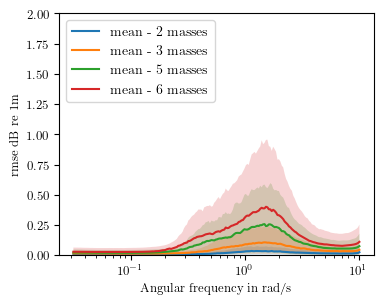

In [11]:
# RMSE Error over frequency

rcParams["text.usetex"] = True
legend_font_size = 10

fig, ax = plt.subplots(1, 1)
plot = plot_loss(losses_per_f_cond1, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond2, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond3, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond4, f, ax, quantile=0.1)
legend_labels = ["mean - 2 masses", "_", "mean - 3 masses", "_", "mean - 5 masses", "_", "mean - 6 masses", "_"]
ax.legend(legend_labels, ncol = 1, prop = {'size': legend_font_size}, loc = 'upper left')
plot.set_ylim([0.0, 2.0])
#ax.grid(True)
plt.tight_layout()

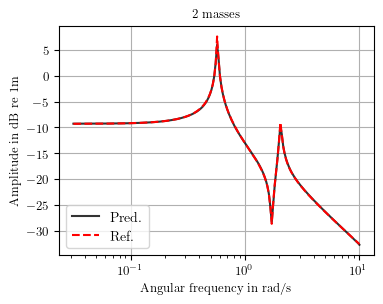

In [12]:
# Prediction for 2 masses
idx_min_loss_1 = np.argmin(loss_per_sample1)
idx_max_loss_1 = np.argmax(loss_per_sample1)


legend_font_size = 10
fig, ax = plt.subplots(1, 1)
i=[0]
num= idx_max_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)

legend_labels = ["Pred.", "Ref."]

plot.set_title("2 masses")
plot.legend(legend_labels, prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()

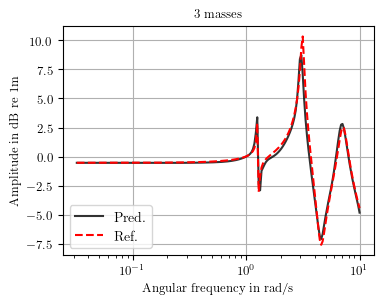

In [13]:
# Prediction for 3 masses

idx_min_loss_2 = np.argmin(loss_per_sample2)
idx_max_loss_2 = np.argmax(loss_per_sample2)

legend_font_size = 10
fig, ax = plt.subplots(1, 1)
i=[0]
num= idx_max_loss_2
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)

legend_labels = ["Pred.", "Ref."]

plot.set_title("3 masses")
plot.legend(legend_labels, prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()

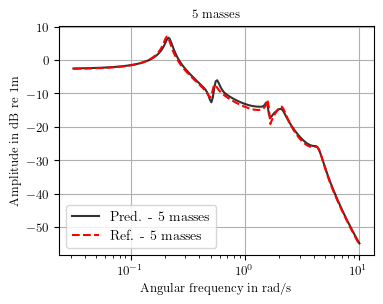

In [14]:
# Prediction for 5 masses

idx_min_loss_3 = np.argmin(loss_per_sample3)
idx_max_loss_3 = np.argmax(loss_per_sample3)


legend_font_size = 10
fig, ax = plt.subplots(1, 1)
i=[2]
num= idx_max_loss_3
plot = plot_results(prediction_cond3[num][:,i], amplitude_cond3[num][:,i], f, ax)

legend_labels = ["Pred. - 5 masses", "Ref. - 5 masses"]

plot.set_title("5 masses")
plot.legend(legend_labels, prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()

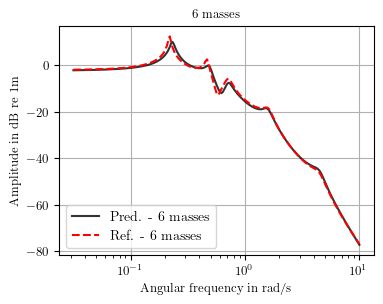

In [15]:
# Prediction for 6 masses

idx_min_loss_4 = np.argmin(loss_per_sample4)
idx_max_loss_4 = np.argmax(loss_per_sample4)


legend_font_size = 10
fig, ax = plt.subplots(1, 1)
i=[3]
num= idx_max_loss_4
plot = plot_results(prediction_cond4[num][:,i], amplitude_cond4[num][:,i], f, ax)

legend_labels = ["Pred. - 6 masses", "Ref. - 6 masses"]

plot.set_title("6 masses")
plot.legend(legend_labels, prop = {'size': legend_font_size}, loc = 'lower left')
plt.tight_layout()